## Creation of a dataset

In deep learning, everything starts with a well-prepared dataset that provides inputs and outputs to the network that is supposed to be trained. Based on the data exploration of the previous notebook, we are creating a dataset class that can serve individual samples to us.

In [1]:
from data import get_dsb2018_train_files, get_dsb2018_validation_files, get_dsb2018_test_files, fill_label_holes, quantile_normalization
from tifffile import imread
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision import transforms

In [3]:
class DSBData():
    def __init__(self, image_files, label_files, target_shape=(256, 256)):
        """
        Parameters
        ----------
        image_files: list of pathlib.Path objects pointing to the *.tif images
        label_files: list of pathlib.Path objects pointing to the *.tif segmentation masks
        target_shape: tuple of length 2 specifying the sample resolutions of files that
                      will be kept. All other files will NOT be used.
        """
        assert len(image_files) == len(label_files)
        assert all(x.name==y.name for x,y in zip(image_files, label_files))

        self.images = []
        self.labels = []

        tensor_transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        for idx in tqdm(range(len(image_files))):
            # we use the same data reading approach as in the previous notebook
            image = imread(image_files[idx])
            label = imread(label_files[idx])

            if image.shape != target_shape:
                continue
            
            # do the normalizations
            image = quantile_normalization(
                image,
                quantile_low=0.01,
                quantile_high=0.998,
                clip=True)[0].astype(np.float32)

            # NOTE: we convert the label to dtype float32 and not uint8 because
            # the tensor transformation does a normalization if the input is of
            # dtype uint8, destroying the 0/1 labelling which we want to avoid.
            label = fill_label_holes(label)
            label_binary = np.zeros_like(label).astype(np.float32)
            label_binary[label != 0] = 1.
            
            # convert to torch tensor: adds an artificial color channel in the front
            # and scales inputs to have same size as samples tend to differ in image
            # resolutions
            image = tensor_transform(image)
            label = tensor_transform(label_binary)

            self.images.append(image)
            self.labels.append(label)
            
        self.images = torch.stack(self.images)
        self.labels = torch.stack(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

    def __len__(self):
        return len(self.images)

In [4]:
train_img_files, train_lbl_files = get_dsb2018_train_files()

n_samples = len(train_img_files)

train_data = DSBData(
    image_files=train_img_files[:n_samples],
    label_files=train_lbl_files[:n_samples],
    target_shape=(256, 256)
)

# NOTE: the length of the dataset might not be the same as n_samples
#       because files not having the target shape will be discarded
print(len(train_data))

100%|██████████| 382/382 [00:36<00:00, 10.46it/s]


232


In [5]:
print(train_data.images.shape, train_data.labels.shape)

torch.Size([232, 1, 256, 256]) torch.Size([232, 1, 256, 256])


In [6]:
print(train_data.images.min(), train_data.images.max())

tensor(0.) tensor(1.)


In [7]:
print(train_data.labels.unique())

tensor([0., 1.])


In [8]:
val_img_files, val_lbl_files = get_dsb2018_validation_files()

n_samples = len(val_img_files)

val_data = DSBData(
    image_files=val_img_files[:n_samples],
    label_files=val_lbl_files[:n_samples],
    target_shape=(256, 256)
)

# NOTE: the length of the dataset might not be the same as n_samples
#       because files not having the target shape will be discarded
print(len(val_data))

100%|██████████| 65/65 [00:14<00:00,  4.52it/s]

44


torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


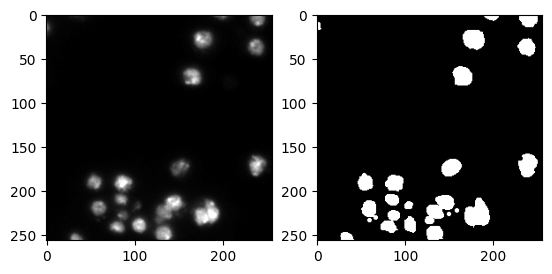

In [9]:
image, label = train_data[0]
print(image.shape, label.shape)

plt.subplot(121)
plt.imshow(image[0].numpy(), cmap="gray")

plt.subplot(122)
plt.imshow(label[0].numpy(), cmap="gray")